In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [8]:
df_res_old

,Chr,SNP,bp,refA,freq,b,se,p,n,freq_geno,bC,bC_se,pC
0,14,rs117448530,78587290,T,0.010484,-0.012691,0.011217,0.257862,328746,0.010086,-0.011215,0.011217,0.317370
1,14,rs17754261,78587899,G,0.239175,0.002324,0.002646,0.379807,336683,0.238813,0.002398,0.002646,0.364814
2,14,rs1119485,78588392,T,0.239176,0.002327,0.002646,0.379169,336661,0.238704,0.002404,0.002646,0.363608
3,14,rs12232088,78589874,C,0.089345,0.002226,0.003963,0.574308,335718,0.088601,0.002566,0.003963,0.517384
4,14,rs34357360,78589975,T,0.225166,0.002026,0.002712,0.455062,334482,0.223520,0.002062,0.002712,0.447023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,14,rs77761105,80382443,A,0.044033,0.005656,0.005588,0.311458,326470,0.041676,0.006369,0.005588,0.254327
4338,14,rs1534836,80382846,G,0.897933,-0.001325,0.003728,0.722250,336790,0.898064,-0.000228,0.003728,0.951287
4339,14,rs1534837,80383025,A,0.072866,0.003535,0.004338,0.415120,337531,0.072790,0.001776,0.004338,0.682252
4340,14,rs1534838,80383152,A,0.102071,0.001317,0.003728,0.723973,336782,0.101938,0.000219,0.003728,0.953103


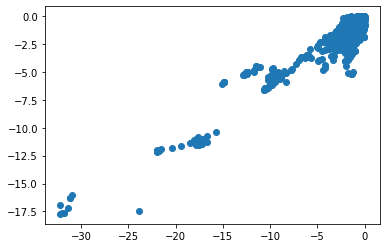

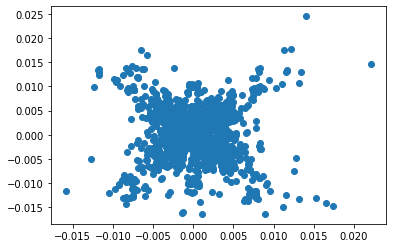

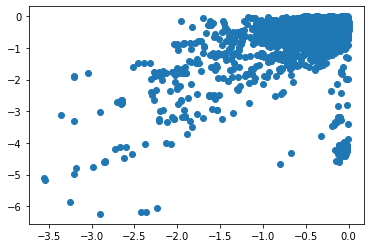

In [9]:
# Compare results with Ang Li's
cojo_res_li = '/n/groups/price/martin/LDSPEC_data/res_cojo_rv1/bmi_NRXN3_Li/Chr14_NRXN3.txt' # BMI
cojo_res_old = '/n/groups/price/martin/gene_dir_effect/res_cojo_100kb/body_BMIz/ENSG00000021645.NRXN3.14.snplist'
cojo_res = '/n/groups/price/martin/LDSPEC_data/res_cojo_rv1/res_cojo_100kb/body_BMIz/ENSG00000021645.NRXN3.14.snplist'

df_res_li = pd.read_csv(cojo_res_li+'.cma.cojo', sep='\t')
df_res_li.index = df_res_li['SNP']
df_res_old = pd.read_csv(cojo_res_old+'.cma.cojo', sep='\t')
df_res_old.index = df_res_old['SNP']
df_res = pd.read_csv(cojo_res+'.cma.cojo', sep='\t')
df_res.index = df_res['SNP']

snp_list = [x for x in df_res_li['SNP'] if x in df_res['SNP']]

# pval
plt.figure()
plt.scatter(np.log10(df_res_li.loc[snp_list, 'p']), np.log10(df_res.loc[snp_list, 'p']))
plt.show()

# bC
plt.figure()
plt.scatter(df_res_li.loc[snp_list, 'bC'], df_res.loc[snp_list, 'bC'])
plt.show()

# pC
plt.figure()
plt.scatter(np.log10(df_res_li.loc[snp_list, 'pC']), np.log10(df_res.loc[snp_list, 'pC']))
plt.show()

### Load data

In [2]:
def dir_eff_LiAjhg2023(file_jma, file_ldr, gene_file):
    """ Estimate masking / concordant effects following the recipe of Li AJHG 2023
    
    A gene is identified as a putative masking gene if it had at least 2 joint SNP effects
    detected by COJO, with the top associated SNP at the genome-wide significant 
    level of pjoint < 5e-8, a secondary SNP at a relaxed significant level of pjoint < 5e-6, 
    and the genetic covariance between the two SNPs being negative (i.e., b1 r b2 < 0).
    
    Parameters
    ----------
    file_jma : str/
        COJO jma.cojo file
    file_ldr : str
        COJO ldr.cojo file

    Returns
    -------
    mat_ld : np.array(dtype=np.float32)
        LD matrix of shape (n_snp_ref, n_snp_tar).
    """
    df_jma = pd.read_csv(file_jma, sep='\t')
    df_jma.index = df_jma['SNP']
    df_ldr = pd.read_csv(file_ldr, sep='\t', index_col=0)
    
    if df_jma.shape[0]<2: # at least two 
        return None
    
    df_jma.sort_values(by='pJ', ascending=True, inplace=True)
    snp1 = df_jma.index[0]
    snp2 = df_jma.index[1]
    
    if (df_jma.loc[snp1, 'pJ']>5e-8) | (df_jma.loc[snp2, 'pJ']>5e-6):
        return None
    
    b1_r_b2 = df_jma.loc[snp1, 'bJ'] * df_jma.loc[snp2, 'bJ'] * df_ldr.loc[snp1, snp2]
    
    ds_res = pd.Series(
        data=[gene_file, b1_r_b2, snp1, snp2, df_jma.loc[snp1, 'freq'], df_jma.loc[snp2, 'freq'], 
              df_jma.loc[snp1, 'bJ'], df_jma.loc[snp2, 'bJ'], df_ldr.loc[snp1, snp2]],
        index=['gene', 'b1_r_b2', 'snp1', 'snp2', 'freq1', 'freq2', 'bJ1', 'bJ2', 'r'],
    )
    
    return ds_res

In [6]:
GENE_FILE_LIST=pd.read_csv(
    '/n/groups/price/martin/gene_dir_effect/gene_annotation/gene_level_snp_1mb.txt',
    sep='\t', header=None
)[2].tolist()

RES_PATH='/n/groups/price/martin/gene_dir_effect/res_cojo'
dic_res = {}
for trait in os.listdir(RES_PATH):
    ds_list = []
    for gene_file in GENE_FILE_LIST:
        file_jma = '%s/%s/%s.jma.cojo'%(RES_PATH, trait, gene_file)
        file_ldr = '%s/%s/%s.ldr.cojo'%(RES_PATH, trait, gene_file)
        if os.path.exists(file_jma):
            ds_res = dir_eff_LiAjhg2023(file_jma, file_ldr, gene_file)
            if ds_res is not None:
                ds_list.append(ds_res.copy())
    df_res = pd.concat(ds_list, axis=1).T
    dic_res[trait] = df_res.copy()  

In [7]:
# Check genes reported in Li AJHG 2023
trait = 'biochemistry_Urate'
gene_list = [
    'ALS2CL', 'TMIE', 'PRSS50', 'PRSS46', 'PRSS45', 'GPR4', 'GRM2', 'CACNA2D2', 
    'TCF4', 'LOC101927789', 'AGAP11', 'PFKFB4', 'CELSR3', 'NBAS', 'FUK', 'COG4', 
    'CCDC51', 'TMA7', 'ATRIP', 'TREX1', 'ODF1', 
]

gene_list = [y for x in gene_list for y in GENE_FILE_LIST if x in y]


In [8]:
dic_res[trait].loc[dic_res[trait]['gene'].isin(gene_list)]

,gene,b1_r_b2,snp1,snp2,freq1,freq2,bJ1,bJ2,r
656,ENSG00000103051.COG4.16.snplist,-0.508983,rs112309706,rs35530425,0.015089,0.469384,4.88014,1.02493,-0.10176
980,ENSG00000007402.CACNA2D2.3.snplist,1.05603,rs6800913,rs535447401,0.250975,0.07079,1.24916,1.95788,0.431788
1064,ENSG00000164082.GRM2.3.snplist,0.260066,rs6802320,rs11929028,0.330015,0.078259,-1.24154,1.85321,-0.113031
1085,ENSG00000178038.ALS2CL.3.snplist,0.315072,rs78580841,rs1466275,0.071083,0.419822,1.75007,-0.794252,-0.226671
1089,ENSG00000181585.TMIE.3.snplist,0.315072,rs78580841,rs1466275,0.071083,0.419822,1.75007,-0.794252,-0.226671
1097,ENSG00000188086.PRSS45P.3.snplist,0.319674,rs78580841,rs11130123,0.071083,0.595499,1.7463,0.830063,0.220535
1115,ENSG00000283706.PRSS50.3.snplist,0.315072,rs78580841,rs1466275,0.071083,0.419822,1.75007,-0.794252,-0.226671


In [3]:
GENE_FILE_LIST=pd.read_csv(
    '/n/groups/price/martin/gene_dir_effect/gene_annotation/gene_level_snp_100kb.txt',
    sep='\t', header=None
)[2].tolist()

RES_PATH='/n/groups/price/martin/gene_dir_effect/res_cojo_100kb'
dic_res = {}
for trait in os.listdir(RES_PATH):
    ds_list = []
    for gene_file in GENE_FILE_LIST:
        file_jma = '%s/%s/%s.jma.cojo'%(RES_PATH, trait, gene_file)
        file_ldr = '%s/%s/%s.ldr.cojo'%(RES_PATH, trait, gene_file)
        if os.path.exists(file_jma):
            ds_res = dir_eff_LiAjhg2023(file_jma, file_ldr, gene_file)
            if ds_res is not None:
                ds_list.append(ds_res.copy())
    df_res = pd.concat(ds_list, axis=1).T
    dic_res[trait] = df_res.copy()  

In [4]:
# Check genes reported in Li AJHG 2023
trait = 'biochemistry_Urate'
gene_list = [
    'ALS2CL', 'TMIE', 'PRSS50', 'PRSS46', 'PRSS45', 'GPR4', 'GRM2', 'CACNA2D2', 
    'TCF4', 'LOC101927789', 'AGAP11', 'PFKFB4', 'CELSR3', 'NBAS', 'FUK', 'COG4', 
    'CCDC51', 'TMA7', 'ATRIP', 'TREX1', 'ODF1', 
]

gene_list = [y for x in gene_list for y in GENE_FILE_LIST if x in y]


In [5]:
dic_res[trait].loc[dic_res[trait]['gene'].isin(gene_list)]

,gene,b1_r_b2,snp1,snp2,freq1,freq2,bJ1,bJ2,r
280,ENSG00000103051.COG4.16.snplist,0.24279,rs113501294,rs35949039,0.016804,0.105744,3.82346,-1.45168,-0.0437424
361,ENSG00000007402.CACNA2D2.3.snplist,-0.241869,rs79821347,rs78342753,0.069775,0.012886,2.46006,3.50383,-0.0280603
362,ENSG00000008300.CELSR3.3.snplist,-0.16288,rs2228561,3:48747279_AAATT_A,0.143076,0.986235,1.3163,-3.69848,0.0334572
380,ENSG00000114268.PFKFB4.3.snplist,-0.238895,rs62261468,rs115744844,0.072983,0.983954,2.32556,-3.3408,0.0307488
419,ENSG00000164051.CCDC51.3.snplist,-0.235716,rs148263510,rs146948889,0.086929,0.013291,2.0332,3.5705,-0.0324698
420,ENSG00000164053.ATRIP.3.snplist,-0.235716,rs148263510,rs146948889,0.086929,0.013291,2.0332,3.5705,-0.0324698
430,ENSG00000164082.GRM2.3.snplist,-0.243951,rs11929028,rs148456775,0.078259,0.023945,2.12473,2.69499,-0.0426031
464,ENSG00000213689.TREX1.3.snplist,-0.235716,rs148263510,rs146948889,0.086929,0.013291,2.0332,3.5705,-0.0324698
467,ENSG00000232112.TMA7.3.snplist,-0.235716,rs148263510,rs146948889,0.086929,0.013291,2.0332,3.5705,-0.0324698


In [11]:
len(gene_list)

19